In [ ]:
from pathlib import Path
import pandas as pd

current_dirr = Path.cwd()
data_dirr = current_dirr / "data"

roster = pd.read_csv(
    data_dirr / "roster.csv",
    converters={"NetID": str.lower, "Email Address": str.lower},
    usecols=["Section", "Email Address", "NetID"],
    index_col="NetID",
)

hw_exam_grades = pd.read_csv(
    data_dirr/ "hw_exam_grades.csv",
    converters={"SID": str.lower},
    usecols=lambda x: "Submission" not in x,
    index_col="SID",
)

quiz_grades = pd.DataFrame()
for file_path in data_dirr.glob("quiz_*_grades.csv"):
    quiz_name = " ".join(file_path.stem.title().split("_")[:2])
    quiz = pd.read_csv(
        file_path,
        converters={"Email": str.lower},
        index_col=["Email"],
        usecols=["Email", "Grade"],
    ).rename(columns={"Grade": quiz_name})
    quiz_grades = pd.concat([quiz_grades, quiz], axis=1)


In [ ]:
final_data = pd.merge(
    roster,
    hw_exam_grades,
    left_index=True,
    right_index=True,
)
final_data = pd.merge(
    final_data, quiz_grades, left_on="Email Address", right_index=True
)
final_data = final_data.fillna(0)


In [ ]:
import numpy as np

In [ ]:
n_exams = 3
for n in range(1, n_exams + 1):
    final_data[f"Exam {n} Score"] = (
        final_data[f"Exam {n}"] / final_data[f"Exam {n} - Max Points"]
    )

homework_scores = final_data.filter(regex=r"^Homework \d\d?$", axis=1)
homework_max_points = final_data.filter(regex=r"^Homework \d\d? -", axis=1)

sum_of_hw_scores = homework_scores.sum(axis=1)
sum_of_hw_max = homework_max_points.sum(axis=1)
final_data["Total Homework"] = sum_of_hw_scores / sum_of_hw_max

hw_max_renamed = homework_max_points.set_axis(homework_scores.columns, axis=1)
average_hw_scores = (homework_scores / hw_max_renamed).sum(axis=1)
final_data["Average Homework"] = average_hw_scores / homework_scores.shape[1]

final_data["Homework Score"] = final_data[
    ["Total Homework", "Average Homework"]
].max(axis=1)

quiz_scores = final_data.filter(regex=r"^Quiz \d$", axis=1)
quiz_max_points = pd.Series(
    {"Quiz 1": 11, "Quiz 2": 15, "Quiz 3": 17, "Quiz 4": 14, "Quiz 5": 12}
)

sum_of_quiz_scores = quiz_scores.sum(axis=1)
sum_of_quiz_max = quiz_max_points.sum()
final_data["Total Quizzes"] = sum_of_quiz_scores / sum_of_quiz_max

average_quiz_scores = (quiz_scores / quiz_max_points).sum(axis=1)
final_data["Average Quizzes"] = average_quiz_scores / quiz_scores.shape[1]

final_data["Quiz Score"] = final_data[
    ["Total Quizzes", "Average Quizzes"]
].max(axis=1)

weightings = pd.Series(
    {
        "Exam 1 Score": 0.05,
        "Exam 2 Score": 0.1,
        "Exam 3 Score": 0.15,
        "Quiz Score": 0.30,
        "Homework Score": 0.4,
    }
)

final_data["Final Score"] = (final_data[weightings.index] * weightings).sum(
    axis=1
)
final_data["Ceiling Score"] = np.ceil(final_data["Final Score"] * 100)

grades = {
    90: "A",
    80: "B",
    70: "C",
    60: "D",
    0: "F",
}


def grade_mapping(value):
    """Map numerical grade to letter grade."""
    for key, letter in grades.items():
        if value >= key:
            return letter


letter_grades = final_data["Ceiling Score"].map(grade_mapping)
final_data["Final Grade"] = pd.Categorical(
    letter_grades, categories=grades.values(), ordered=True
)


In [ ]:
for section, table in final_data.groupby("Section"):
    section_file = data_dirr / f"Section {section} Grades.csv"
    num_students = table.shape[0]
    print(
        f"In Section {section} there are {num_students} students saved to "
        f"file {section_file}."
    )
    table.sort_values(by=["Last Name", "First Name"]).to_csv(section_file)


In Section 1 there are 56 students saved to file /content/data/Section 1 Grades.csv.
In Section 2 there are 51 students saved to file /content/data/Section 2 Grades.csv.
In Section 3 there are 43 students saved to file /content/data/Section 3 Grades.csv.


In [ ]:
import matplotlib.pyplot as plt
import scipy

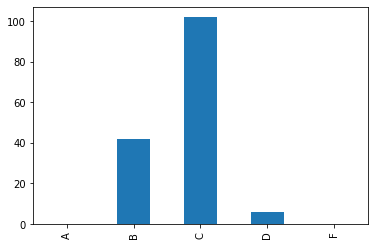

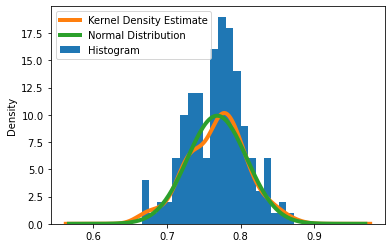

In [ ]:
grade_counts = final_data["Final Grade"].value_counts().sort_index()
grade_counts.plot.bar()
plt.show()

final_data["Final Score"].plot.hist(bins=20, label="Histogram")
final_data["Final Score"].plot.density(
    linewidth=4, label="Kernel Density Estimate"
)

final_mean = final_data["Final Score"].mean()
final_std = final_data["Final Score"].std()
x = np.linspace(final_mean - 5 * final_std, final_mean + 5 * final_std, 200)
normal_dist = scipy.stats.norm.pdf(x, loc=final_mean, scale=final_std)
plt.plot(x, normal_dist, label="Normal Distribution", linewidth=4)
plt.legend()
plt.show()
